[← Previous: Dataset Comparison - Human vs AI Labels](05_dataset_comparison_analysis.ipynb)

# **Building a Random Forest for Anxiety Trigger Classification**

**The Goal:** To see if a random forest classifier can predict which Reddit posts trigger high anxiety.

**The Approach:** Compare three labeling strategies (hand-annotated, AI-generated, and combined) to find the optimal balance between annotation quality and dataset size.

**The Result:** Performance metrics and model selection are reported below.


---


## Table of Contents

1. [Setup](#1-setup)
2. [Load Pre-trained Models](#2-load-pre-trained-models)
3. [Create Three Label Sets](#3-create-three-label-sets)
4. [Build Features](#4-build-features)
5. [Train and Compare](#5-train-and-compare)
6. [Save Model for Production](#6-save-model-for-production)
7. [Generate Report Statistics](#7-generate-report-statistics)
8. [Limitations and Future Work](#8-limitations-and-future-work)

[Next: Text Classification with Logistic Regression →](10_text_classification_logreg_final.ipynb)


---


In [12]:
# remove -q to see output
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


---

## **1. Setup**

Import libraries, set paths, define random seed for reproducibility.

In [13]:
# Standard Library
import os
import json
import warnings
from pathlib import Path

# Data Processing
import numpy as np
import pandas as pd
import joblib

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)

# Sparse Matrix Operations
from scipy.sparse import hstack, csr_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# CONFIGURATION
# Reproducibility
SEED = 42
np.random.seed(SEED)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Project Paths
DATA = Path("../data")                # Raw data directory
PROC = DATA / "processed"             # Processed data
ART = Path("../artifacts")            # Saved models, vectorizers, outputs

# Tokenization Rules
TEXT_COL = "text_all"                 # Column containing full post text
PUNCT = ".,!?:;()[]{}\"'""''-–—/\\"   # Characters to strip from word boundaries
TRASH = {                             # Domain-specific noise to remove
    "[text]", 
    "[image]", 
    "[removed]", 
    "[deleted]"
}
KEEP_SHORT = {                         # Mental health terms to preserve
    "ecg", 
    "sad", 
    "ptsd", 
    "mom", 
    "dad", 
    "anx"
}


# TOKENIZATION FUNCTION
def tokenize(s):
    """
    Tokenize text with domain-specific rules for mental health posts.
    
    Rules:
    - Strip punctuation and lowercase
    - Remove Reddit artifacts ([removed], [deleted], etc.)
    - Keep words ≥3 characters OR domain-specific short terms
    
    Args:
        s (str): Input text
        
    Returns:
        list: Cleaned tokens
    """
    tokens = []
    for word in str(s).split():
        word = word.strip().strip(PUNCT).lower()
        if word and word not in TRASH and (len(word) >= 3 or word in KEEP_SHORT):
            tokens.append(word)
    return tokens


# CONFIRMATION
print("Setup complete")
print(f"  - Data path: {PROC}")
print(f"  - Artifacts path: {ART}")
print(f"  - Random seed: {SEED}")
print(f"  - Tokenization: {len(KEEP_SHORT)} special terms preserved")

Setup complete
  - Data path: ../data/processed
  - Artifacts path: ../artifacts
  - Random seed: 42
  - Tokenization: 6 special terms preserved


---

## **2. Load Pre-trained Models**

Load the components needed for supervised classification. In this section we combine the pre-trained feature extractors (from unsupervised learning) with newly created labels to train our anxiety classifier.

**What we're loading and why:**

| Component | Source | Purpose |
|-----------|--------|---------|
| **Main Dataset** | `reddit_anxiety_v1.parquet` | 6,283 Reddit posts with preprocessed text |
| **Hand Labels** | `sample_human_labels.csv` | 599 posts rated by human annotator  |
| **AI Labels** | `simple_ai_labels.csv` | 1,000 posts labeled by rule-based classification |
| **TF-IDF Vectorizer** | `vec_final.joblib` | Pre-trained on all 6,283 posts -> converts text to ~9,699 features |
| **NMF Topic Model** | `nmf_final.joblib` | Pre-trained on all 6,283 posts -> extracts 15 topic distributions |

**Why are we using pre-trained?** The TF-IDF and NMF models learned general patterns from *all* posts (unlabeled), which would ideally give us better vocabulary coverage and topic definitions than training only on the 1,006 labeled posts.

In [14]:
# ============================================================================
# LOAD DATA AND ARTIFACTS
# ============================================================================

def identity(x): 
    """Identity function needed for unpickling TF-IDF vectorizer with custom tokenizer."""
    return x

df = pd.read_parquet(PROC / "reddit_anxiety_v1.parquet")
vec = joblib.load(ART / "vec_final.joblib")
nmf = joblib.load(ART / "nmf_final.joblib")
df_hand = pd.read_csv(PROC / "sample_human_labels.csv")
df_ai = pd.read_csv(PROC / "simple_ai_labels.csv")

print(f"\n{'='*60}\nLOADED DATA\n{'='*60}")
print(f"Posts: {len(df):,} | TF-IDF: {vec.max_features:,} features | "
      f"Topics: {nmf.n_components}")
print(f"Labels: {len(df_hand):,} hand | {len(df_ai):,} AI")
print(f"{'='*60}")


LOADED DATA
Posts: 6,283 | TF-IDF: 10,000 features | Topics: 15
Labels: 599 hand | 1,000 AI


In [15]:
# ============================================================================
# VERIFICATION: check feature dimensions
# ============================================================================

print(f"\n{'='*60}\nFEATURE VERIFICATION\n{'='*60}")

print(f"TF-IDF: {vec.max_features:,} max features")
print(f"NMF Topics: {nmf.n_components} topics")

sample_text = df[TEXT_COL].iloc[0]
sample_tokens = tokenize(sample_text)

print(f"\nSample post: {len(sample_text)} chars → {len(sample_tokens)} tokens")
print(f"First 5 tokens: {sample_tokens[:5]}")

X_tfidf_sample = vec.transform([sample_tokens])
W_topics_sample = nmf.transform(X_tfidf_sample)

doc_len_val = len(sample_tokens)
has_url_val = int("http" in sample_text.lower())
nrc_val = df["anxiety_score"].iloc[0] if "anxiety_score" in df.columns else 0.0

print(f"\nMetadata: doc_len={doc_len_val}, has_url={has_url_val}, nrc_score={nrc_val:.3f}")

total_features = X_tfidf_sample.shape[1] + W_topics_sample.shape[1] + 3

print(f"\nTotal features: {X_tfidf_sample.shape[1]:,} (TF-IDF) + "
      f"{W_topics_sample.shape[1]} (topics) + 3 (metadata) = {total_features:,}")
print(f"{'='*60}")


FEATURE VERIFICATION
TF-IDF: 10,000 max features
NMF Topics: 15 topics

Sample post: 1170 chars → 164 tokens
First 5 tokens: ['how', 'you', 'calm', 'your', 'mind']

Metadata: doc_len=164, has_url=0, nrc_score=0.000

Total features: 9,699 (TF-IDF) + 15 (topics) + 3 (metadata) = 9,717


---

## **3. Create Three Label Sets**

Compare three labeling strategies: hand-annotated, AI-generated, and combined.

**Labeling Criteria:**
- **Hand-annotated:** Single annotator rated posts on 0-5 scale. High anxiety threshold = rating ≥4.
- **AI-generated:** Posts labeled using NRC Emotion Lexicon with anxiety/panic category, severity ≥4, and confidence ≥0.5.
- **Combined:** Union of both sources. For overlapping posts, prioritize hand labels over AI labels.

**Note:** Actual dataset sizes and class distributions are reported in the code output below.

*Limitation: Hand labels represent single-annotator judgment without inter-annotator reliability validation (see Section 8).*

In [16]:
# ============================================================================
# CREATE LABEL SETS FOR MODEL TRAINING
# ============================================================================

label_sets = {}

# 1. HAND-ANNOTATED LABELS
print(f"\n{'='*60}\nProcessing labels\n{'='*60}")

df_h = df_hand[["post_id"]].copy()

if "anxiety_rating" in df_hand.columns:
    rating = pd.to_numeric(df_hand["anxiety_rating"], errors="coerce")
    df_h["label"] = (rating >= 4).astype(int)
else:
    raise ValueError("anxiety_rating column not found in hand-annotated data")

print(f"Hand: {len(df_h)} posts | {df_h['label'].sum()} positive ({100*df_h['label'].mean():.1f}%)")

label_sets["hand"] = df_h

# 2. AI-GENERATED LABELS
cat = df_ai["ai_category"].astype(str).str.lower()
conf = pd.to_numeric(df_ai["ai_confidence"], errors="coerce").fillna(0)
sev = pd.to_numeric(df_ai["ai_severity"], errors="coerce").fillna(0)

df_a = df_ai[["post_id"]].copy()
df_a["label"] = (
    (cat.str.contains("anx") | cat.str.contains("panic")) &
    (sev >= 4) &
    (conf >= 0.5)
).astype(int)

print(f"AI:   {len(df_a)} posts | {df_a['label'].sum()} positive ({100*df_a['label'].mean():.1f}%)")

label_sets["ai"] = df_a

# 3. COMBINED LABELS
df_h_temp = df_h.copy()
df_h_temp["source"] = "hand"

df_a_temp = df_a.copy()
df_a_temp["source"] = "ai"

df_comb = pd.concat([df_h_temp, df_a_temp], ignore_index=True)
df_comb = df_comb.sort_values("source").drop_duplicates("post_id", keep="last")

overlap = len(df_h) + len(df_a) - len(df_comb)

print(f"Comb: {len(df_comb)} posts | {df_comb['label'].sum()} positive ({100*df_comb['label'].mean():.1f}%) | "
      f"Overlap: {overlap}")

label_sets["combined"] = df_comb[["post_id", "label"]]

print(f"\nNote: Hand labels prioritized for {overlap} overlapping posts")
print(f"{'='*60}")


Processing labels
Hand: 599 posts | 114 positive (19.0%)
AI:   1000 posts | 147 positive (14.7%)
Comb: 1006 posts | 173 positive (17.2%) | Overlap: 593

Note: Hand labels prioritized for 593 overlapping posts


---

## **4. Build Features**

Convert text into numerical features that Random Forest can learn from. We combine three complementary feature types to capture both lexical patterns and semantic meaning.

**Feature composition (9,717 per post):**
- **9,699 TF-IDF scores:** Which words appear and how important they are (pre-trained vocabulary)
- **15 topic probabilities:** What themes/topics the post discusses (pre-trained NMF model)
- **3 metadata features:** Post characteristics (doc length, URL presence, optional NRC score if available)

**Why did we choose this combination?** TF-IDF captures specific anxiety-related words ("panic", "attack"), topics capture broader themes (health anxiety vs. social anxiety), and metadata provides context. Together they give a richer representation than text alone.


```mermaid
flowchart LR
    A[Raw Text Post] --> B[Tokenize Text]
    B --> C{Split into<br/>3 Paths}
    
    C --> D[TF-IDF<br/>Vectorizer]
    C --> E[NMF<br/>Topic Model]
    C --> F[Metadata<br/>Extraction]
    
    D --> G[9,699<br/>word scores]
    E --> H[15 topic<br/>probabilities]
    F --> I[3 features:<br/>length, URL, NRC]
    
    G --> J[Horizontal<br/>Stack]
    H --> J
    I --> J
    
    J --> K[Final Feature Matrix<br/>9,717 features<br/>Ready for Random Forest]
    
    style A fill:#818CF8,stroke:#6366F1,stroke-width:3px,color:#fff
    style B fill:#60A5FA,stroke:#3B82F6,stroke-width:2px,color:#fff
    style C fill:#FB7185,stroke:#E11D48,stroke-width:2px,color:#fff
    style D fill:#A78BFA,stroke:#8B5CF6,stroke-width:2px,color:#fff
    style E fill:#A78BFA,stroke:#8B5CF6,stroke-width:2px,color:#fff
    style F fill:#A78BFA,stroke:#8B5CF6,stroke-width:2px,color:#fff
    style G fill:#2DD4BF,stroke:#14B8A6,stroke-width:2px,color:#000
    style H fill:#2DD4BF,stroke:#14B8A6,stroke-width:2px,color:#000
    style I fill:#2DD4BF,stroke:#14B8A6,stroke-width:2px,color:#000
    style J fill:#60A5FA,stroke:#3B82F6,stroke-width:2px,color:#fff
    style K fill:#10B981,stroke:#059669,stroke-width:3px,color:#fff
```

In [17]:
# ============================================================================
# BUILD FEATURES FOR EACH LABEL SET
# ============================================================================

datasets = {}  # Store X, y for each label source

print(f"\n{'='*60}\nBUILDING FEATURES\n{'='*60}")

for name, df_labels in label_sets.items():
    
    # 1. PREPARE DATA: Match labeled posts to main dataset
    df_subset = df[df['post_id'].isin(df_labels['post_id'])].copy()
    df_subset = df_subset.merge(df_labels, on='post_id', how='inner')
    
    # Tokenize text for vectorization
    tokens = df_subset[TEXT_COL].fillna("").map(tokenize)
    
    # 2. EXTRACT FEATURES
    # Feature Type 1: TF-IDF (text importance)
    X_tfidf = vec.transform(tokens)
    
    # Feature Type 2: NMF Topics (semantic themes)
    W_topics = nmf.transform(X_tfidf)
    
    # Feature Type 3: Metadata Features
    doc_len = np.array([len(t) for t in tokens])[:, None]                    # Document length
    has_url = df_subset[TEXT_COL].fillna("")\
                       .str.contains("http", case=False)\
                       .astype(int).values[:, None]                          # URL indicator
    nrc = df_subset.get("anxiety_score", pd.Series(0, index=df_subset.index))\
                   .fillna(0).values[:, None]                                # NRC anxiety score
    
    # 3. COMBINE FEATURES
    # Stack dense features: Topics (15) + doc_len (1) + has_url (1) + nrc (1)
    X_dense = np.hstack([W_topics, doc_len, has_url, nrc])
    X_dense = np.nan_to_num(X_dense, nan=0.0)
    
    # Combine sparse TF-IDF + dense features
    X = hstack([X_tfidf, csr_matrix(X_dense)], format="csr")
    X.data = np.nan_to_num(X.data, nan=0.0)
    
    # 4. EXTRACT LABELS & STORE
    y = df_subset["label"].values
    datasets[name] = {"X": X, "y": y}
    
    print(f"{name:10s} | X: {X.shape} | y: {len(y):4d} | "
          f"pos: {y.sum():3d} ({100*y.mean():4.1f}%)")

print(f"\nFeatures: {X_tfidf.shape[1]:,} TF-IDF + {W_topics.shape[1]} topics + "
      f"3 metadata = {X.shape[1]:,} total")
print(f"{'='*60}")


BUILDING FEATURES
hand       | X: (599, 9717) | y:  599 | pos: 114 (19.0%)
ai         | X: (1000, 9717) | y: 1000 | pos: 147 (14.7%)
combined   | X: (1006, 9717) | y: 1006 | pos: 173 (17.2%)

Features: 9,699 TF-IDF + 15 topics + 3 metadata = 9,717 total


---

## **5. Train and Compare**

**Method:** 80/20 train-test split, Random Forest (600 trees), optimize F1 threshold for each model

**Approach:** Train separate models on each label source and compare performance metrics (AUC, Average Precision, optimal threshold).

**Why Random Forest?** This method handles high-dimensional sparse features well without requiring feature scaling or extensive hyperparameter tuning.

In [18]:
# ============================================================================
# TRAIN RANDOM FOREST ON EACH LABEL SOURCE
# ============================================================================

results = []

for name in ["hand", "ai", "combined"]:
    
    print(f"\n{'='*60}\nTRAINING: {name.upper()}\n{'='*60}")
    
    X = datasets[name]["X"]
    y = datasets[name]["y"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=SEED
    )
    
    print(f"Train: {len(y_train)} | Test: {len(y_test)} | "
          f"Positive: {y_test.mean():.1%}")
    
    rf = RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        class_weight="balanced_subsample", n_jobs=-1, random_state=SEED
    )
    
    rf.fit(X_train, y_train)
    proba = rf.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    
    p, r, t = precision_recall_curve(y_test, proba)
    f1 = 2 * p * r / (p + r + 1e-10)
    best_thr = t[np.argmax(f1)]
    
    print(f"AUC: {auc:.3f} | AP: {ap:.3f} | Threshold: {best_thr:.3f}")
    
    fpr, tpr, _ = roc_curve(y_test, proba)
    
    results.append({
        "source": name, "n": len(y), "pos_rate": y.mean(),
        "auc": auc, "ap": ap, "threshold": best_thr,
        "fpr": fpr, "tpr": tpr
    })


# ============================================================================
# COMPARE ALL LABEL SOURCES
# ============================================================================

df_results = pd.DataFrame(results).sort_values("auc", ascending=False)

print(f"\n{'='*60}\nFINAL COMPARISON\n{'='*60}")
print(df_results[["source", "n", "auc", "ap", "threshold"]].to_string(index=False))

best = df_results.iloc[0]
print(f"\nBest: {best['source'].upper()} (AUC={best['auc']:.3f}, n={int(best['n'])})")
print(f"{'='*60}")

df_results.to_csv(ART / "label_comparison.csv", index=False)


TRAINING: HAND
Train: 479 | Test: 120 | Positive: 19.2%
AUC: 0.845 | AP: 0.571 | Threshold: 0.348

TRAINING: AI
Train: 800 | Test: 200 | Positive: 14.5%
AUC: 0.815 | AP: 0.442 | Threshold: 0.228

TRAINING: COMBINED
Train: 804 | Test: 202 | Positive: 17.3%
AUC: 0.849 | AP: 0.566 | Threshold: 0.349

FINAL COMPARISON
  source    n      auc       ap  threshold
combined 1006 0.849102 0.566250   0.349325
    hand  599 0.844913 0.571492   0.347657
      ai 1000 0.814882 0.442403   0.227568

Best: COMBINED (AUC=0.849, n=1006)


#### **Visualize Label Source Comparison**


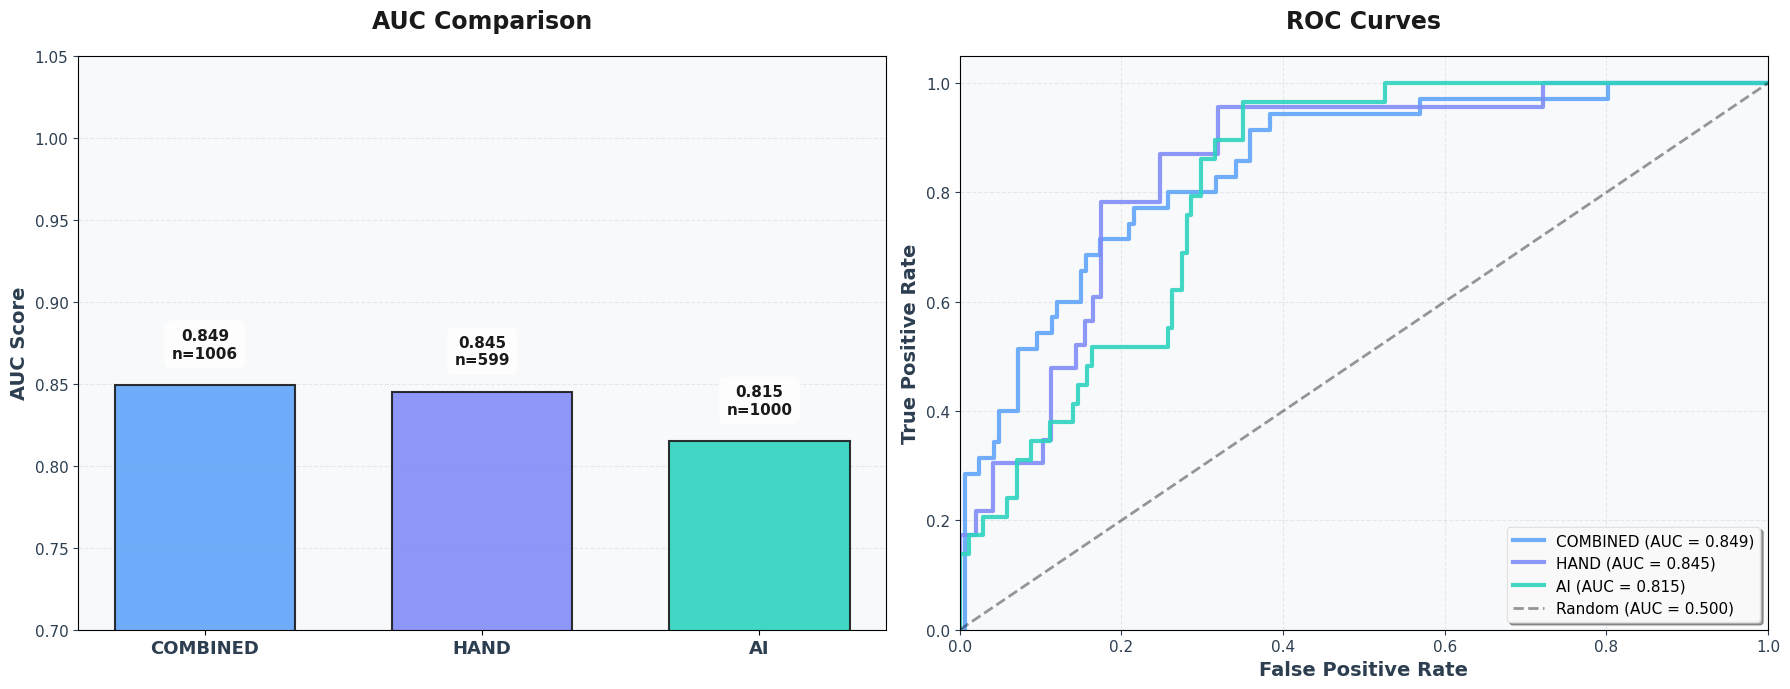

In [19]:
# ============================================================================
# CREATE COMPARISON VISUALIZATION
# ============================================================================

# 1. SETUP: Initialize figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

colors = {
    "hand": "#818CF8",      # Slate Blue - human expertise
    "ai": "#2DD4BF",        # Teal - ai with nrc
    "combined": "#60A5FA"   # Emerald - combined
}

# ============================================================================
# LEFT SUBPLOT: AUC BAR CHART
# ============================================================================

# Create bar chart
x_positions = np.arange(len(df_results))
bars = ax1.bar(
    x_positions, 
    df_results["auc"], 
    color=[colors[source] for source in df_results["source"]],
    width=0.65,
    edgecolor='#1a1a1a',
    linewidth=1.5,
    alpha=0.9
)

# Configure axes
ax1.set_xticks(x_positions)
ax1.set_xticklabels(
    [source.upper() for source in df_results["source"]], 
    fontsize=13,
    fontweight='bold',
    color='#2c3e50'
)

ax1.set_ylabel("AUC Score", fontsize=14, fontweight='bold', color='#2c3e50')
ax1.set_ylim([0.70, 1.0])
ax1.set_yticks(np.arange(0.70, 1.05, 0.05))
ax1.tick_params(axis='y', labelsize=11, colors='#2c3e50')

# Title and styling
ax1.set_title(
    "AUC Comparison", 
    fontsize=17, 
    fontweight="bold",
    color='#1a1a1a',
    pad=20
)

ax1.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.8, color='#95a5a6')
ax1.set_axisbelow(True)
ax1.set_facecolor('#f8f9fa')

# Add value labels on bars
for i, (idx, row) in enumerate(df_results.iterrows()):
    ax1.text(
        i, 
        row["auc"] + 0.015,
        f'{row["auc"]:.3f}\nn={int(row["n"])}', 
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=11,
        color='#1a1a1a',
        bbox=dict(
            boxstyle='round,pad=0.5',
            facecolor='white',
            edgecolor='none',
            alpha=0.8
        )
    )

# ============================================================================
# RIGHT SUBPLOT: ROC CURVES
# ============================================================================

# Plot ROC curve for each label source
for _, row in df_results.iterrows():
    source = row["source"]
    ax2.plot(
        row["fpr"], 
        row["tpr"], 
        color=colors[source],
        linewidth=3,
        alpha=0.9,
        label=f'{source.upper()} (AUC = {row["auc"]:.3f})'
    )

# Plot diagonal reference line (random classifier)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.4, label='Random (AUC = 0.500)')

# Configure axes
ax2.set_xlabel("False Positive Rate", fontsize=14, fontweight='bold', color='#2c3e50')
ax2.set_ylabel("True Positive Rate", fontsize=14, fontweight='bold', color='#2c3e50')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.tick_params(labelsize=11, colors='#2c3e50')

# Title and styling
ax2.set_title(
    "ROC Curves", 
    fontsize=17, 
    fontweight="bold",
    color='#1a1a1a',
    pad=20
)

ax2.grid(alpha=0.2, linestyle='--', linewidth=0.8, color='#95a5a6')
ax2.set_axisbelow(True)
ax2.set_facecolor('#f8f9fa')

# Legend with modern styling
legend = ax2.legend(
    loc='lower right',
    fontsize=11,
    frameon=True,
    fancybox=True,
    shadow=True,
    framealpha=0.95,
    edgecolor='#e0e0e0'
)
legend.get_frame().set_facecolor('white')

# Overall figure styling
fig.patch.set_facecolor('white')
plt.tight_layout()

# Save and display
plt.savefig(ART / "images/final_comparison.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


---

## **6. Save Model for Production**

After comparing all three approaches, we select the best-performing model and retrain it on the full dataset (no train-test split) to maximize available training data for production deployment.

In [20]:
# ============================================================================
# RETRAIN BEST MODEL ON FULL DATASET
# ============================================================================

print(f"\n{'='*60}\nRetraining on full dataset (all 1,006 samples)\n{'='*60}")

X_full = datasets["combined"]["X"]
y_full = datasets["combined"]["y"]

print(f"Samples: {len(y_full):,} | Positive: {y_full.sum()} ({100*y_full.mean():.1f}%)")

best_model = RandomForestClassifier(
    n_estimators=600, max_depth=None, min_samples_leaf=2,
    class_weight="balanced_subsample", n_jobs=-1, random_state=SEED
)

best_model.fit(X_full, y_full)
print("Training complete")


# ============================================================================
# SAVE MODEL AND METADATA
# ============================================================================

model_path = ART / "triggerlens_final_model.joblib"
joblib.dump(best_model, model_path)

combined_results = df_results[df_results['source'] == 'combined'].iloc[0]
hand_count = len(datasets['hand']['y'])
ai_only_count = len(datasets['ai']['y']) - hand_count
total_features = X_full.shape[1]

metadata = {
    "model_type": "RandomForest",
    "label_source": "combined (hand + AI)",
    "training_info": {
        "n_samples": int(len(y_full)),
        "n_positive": int(y_full.sum()),
        "positive_rate": float(y_full.mean()),
        "n_hand_labels": hand_count,
        "n_ai_labels": ai_only_count
    },
    "performance": {
        "test_auc": float(combined_results['auc']),
        "test_ap": float(combined_results['ap']),
        "optimal_threshold": float(combined_results['threshold'])
    },
    "hyperparameters": {
        "n_estimators": 600,
        "max_depth": None,
        "min_samples_leaf": 2,
        "class_weight": "balanced_subsample"
    },
    "features": {
        "tfidf_vocab_size": int(vec.max_features),
        "tfidf_actual_features": X_full.shape[1] - nmf.n_components - 3,
        "nmf_topics": int(nmf.n_components),
        "metadata_features": 3,
        "total_features": total_features
    },
    "preprocessing": {
        "vectorizer_path": "vec_final.joblib",
        "nmf_model_path": "nmf_final.joblib",
        "text_column": "text_all"
    },
    "date_trained": pd.Timestamp.now().isoformat(),
    "random_seed": SEED
}

meta_path = ART / "triggerlens_final_model_meta.json"
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\nSaved: {model_path.name}")
print(f"Saved: {meta_path.name}")

best_row = df_results.iloc[0]
print(f"\nFinal Model: RF (600 trees) | Features: {total_features:,} | "
      f"Test AUC: {combined_results['auc']:.3f}")
if best_row['source'] != 'combined':
    print(f"Note: {best_row['source'].title()} had higher AUC ({best_row['auc']:.3f}), "
          f"but Combined selected for more data")
print(f"Optimal threshold: {combined_results['threshold']:.3f}")
print(f"{'='*60}")


Retraining on full dataset (all 1,006 samples)
Samples: 1,006 | Positive: 173 (17.2%)
Training complete

Saved: triggerlens_final_model.joblib
Saved: triggerlens_final_model_meta.json

Final Model: RF (600 trees) | Features: 9,717 | Test AUC: 0.849
Optimal threshold: 0.349


---

## **7. Generate Report Statistics**

Generate summary statistics.

In [21]:
# ============================================================================
# FINAL SUMMARY AND REPORT
# ============================================================================

ai_only_count = len(datasets['combined']['y']) - len(datasets['hand']['y'])
overlap_count = len(datasets['hand']['y']) + len(datasets['ai']['y']) - len(datasets['combined']['y'])

print(f"\n{'='*60}\nDATASET & PERFORMANCE SUMMARY\n{'='*60}")
print(f"Total posts: {len(df):,} | Labeled: {len(datasets['combined']['y']):,}")
print(f"Hand: {len(datasets['hand']['y'])} | AI-only: {ai_only_count} | Overlap: {overlap_count}")

best_row = df_results.iloc[0]
combined_row = df_results[df_results['source'] == 'combined'].iloc[0]
hand_row = df_results[df_results['source'] == 'hand'].iloc[0]
ai_row = df_results[df_results['source'] == 'ai'].iloc[0]

print(f"\nTest Performance (Best: {best_row['source'].title()}, AUC={best_row['auc']:.3f}):")
print(f"  Combined: {combined_row['auc']:.3f} AUC | {combined_row['ap']:.3f} AP | n={int(combined_row['n'])}")
print(f"  Hand:     {hand_row['auc']:.3f} AUC | {hand_row['ap']:.3f} AP | n={int(hand_row['n'])}")
print(f"  AI:       {ai_row['auc']:.3f} AUC | {ai_row['ap']:.3f} AP | n={int(ai_row['n'])}")


# ============================================================================
# SAVE REPORT STATISTICS
# ============================================================================

report_path = ART / "report_statistics.txt"

with open(report_path, "w") as f:
    f.write("TriggerLens Final Statistics\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Total posts: {len(df):,}\n")
    f.write(f"Labeled posts: {len(datasets['combined']['y']):,}\n")
    f.write(f"\nTest Performance:\n")
    for _, row in df_results.iterrows():
        marker = " (BEST)" if row['source'] == best_row['source'] else ""
        f.write(f"- {row['source'].title()}: AUC = {row['auc']:.3f}{marker}\n")
    f.write(f"\nProduction Model: Random Forest (600 trees)\n")
    f.write(f"Label strategy: Combined (best performing)\n")

print(f"\nSaved: {report_path.name}\n{'='*60}")


DATASET & PERFORMANCE SUMMARY
Total posts: 6,283 | Labeled: 1,006
Hand: 599 | AI-only: 407 | Overlap: 593

Test Performance (Best: Combined, AUC=0.849):
  Combined: 0.849 AUC | 0.566 AP | n=1006
  Hand:     0.845 AUC | 0.571 AP | n=599
  AI:       0.815 AUC | 0.442 AP | n=1000

Saved: report_statistics.txt


---

## **8. Limitations and Future Work**

**Single-Annotator Labeling:** Our hand-annotated labels reflect one person's judgment without independent verification. Standard practice in NLP annotation requires multiple annotators with inter-rater reliability metrics such as Cohen's Kappa (Artstein & Poesio, 2008) to establish objective quality. Without this validation (κ ≥0.6 for substantial agreement), we cannot distinguish between consistent individual bias and true label quality.

**Label Source Comparison:** We compared three labeling approaches (hand-annotated, AI-generated using NRC Emotion Lexicon, and combined). Performance differences between approaches were relatively small, suggesting that the choice between quality and quantity involves trade-offs. Production model selection considered both test performance and available training data to balance accuracy with robustness.

**Dataset Generalizability:** Our data comes exclusively from Reddit anxiety subreddits during a specific timeframe, which may not represent anxiety expression in other contexts or platforms. The model's language patterns are platform-specific and may have temporal biases.

**Feature Importance:** Text features (TF-IDF + topics) account for ~98.85% of predictive power, while metadata contributes only ~1.15%. This suggests that lexical and semantic patterns are the primary indicators of anxiety severity. 

**Next Steps:** Multi-annotator validation, improved AI label filtering strategies, temporal/engagement feature engineering, and cross-platform validation testing.

In [22]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================

# 1. DEFINE FEATURE NAMES
feature_names = (
    [f"tfidf_{i}" for i in range(9699)] +       # TF-IDF features (9,699)
    [f"topic_{i}" for i in range(15)] +         # NMF topics (15)
    ["doc_length", "has_url", "nrc_score"]      # Metadata features (3)
)

# 2. CALCULATE IMPORTANCE BY FEATURE TYPE
importances = best_model.feature_importances_

# Split importance between text and metadata features
metadata_importance = importances[-3:].sum()    # Last 3 features
text_importance = importances[:-3].sum()        # All text features

# 3. DISPLAY RESULTS
print(f"\n Feature Importance Breakdown:")
print(f"  Text features (TF-IDF + Topics): {100*text_importance:.2f}%")
print(f"  Metadata features: {100*metadata_importance:.2f}%")


 Feature Importance Breakdown:
  Text features (TF-IDF + Topics): 98.85%
  Metadata features: 1.15%


---


### **References**

Artstein, R., & Poesio, M. (2008). Inter-coder agreement for computational linguistics. *Computational Linguistics*, 34(4), 555-596. https://aclanthology.org/J08-4004/

[Next: Text Classification with Logistic Regression →](10_text_classification_logreg_final.ipynb)
